# Lesson 3: Neural Networks and KNN

## Recap Lesson 2

Today, we will learn how to normalize and scale data for use in KNN and neural network methods. Then we will learn how to use KNN and neural network regression to predict the future values of a stock's price.

First, let's load our code from previous lessons:

In [33]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install TA-Lib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install keras==2.3.1

import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
import keras.losses
from keras.layers import Dropout
import tensorflow as tf



lng_df = pd.read_csv('data/lng.csv')
spy_df = pd.read_csv('data/spy.csv')

# Change index for Lesson 2
lng_df.set_index('Date', inplace=True)
lng_df.index = pd.to_datetime(lng_df.index)

spy_df.set_index('Date', inplace=True)
spy_df.index = pd.to_datetime(spy_df.index)


# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]


# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df.dropna()[feature_names]
targets = lng_df.dropna()['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]

# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values,
                        timeperiod=5)

# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)
# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe

lng_df = pd.concat([lng_df, days_of_week], axis=1)
# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place

# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

train_features = lng_df[feature_names].iloc[:250]
test_features = lng_df[feature_names].iloc[250:]

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth = d)
    decision_tree.fit(train_features, train_targets)

# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)

# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
features = lng_df.dropna()[feature_names]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

            5d_close_pct      ma14      rsi14      ma30      rsi30      ma50  \
Date                                                                           
2017-01-31      0.043812  0.950697  62.968946  0.918657  60.655749  0.895731   
2017-02-01     -0.023429  0.967486  60.156019  0.932427  59.159791  0.910110   
2017-02-02     -0.021618  0.932220  66.659314  0.895486  62.988478  0.873379   
2017-02-03      0.007336  0.938976  66.920059  0.899461  63.148741  0.875497   
2017-02-06      0.022129  0.964080  62.059184  0.921608  60.623276  0.895860   
...                  ...       ...        ...       ...        ...       ...   
2018-01-22      0.012059  0.992134  67.454995  0.948517  65.158943  0.918783   
2018-01-23      0.024189  0.964486  74.935143  0.925169  68.970930  0.892687   
2018-01-24      0.039871  0.955403  77.285688  0.919390  70.372876  0.884135   
2018-01-25      0.062918  0.945533  79.745833  0.911759  71.949694  0.873825   
2018-01-26      0.081680  0.932322  82.4

## Standardizing Data
Some models, like K-nearest neighbors (KNN) & neural networks, work better with scaled data - so we'll standardize our data.

We'll also remove unimportant variables (day of week), according to feature importances, by indexing the features DataFrames with `.iloc[]`. KNN uses distances to find similar points for predictions, so big features outweigh small ones. Scaling data fixes that.

`sklearn`'s `scale()` will standardize data, which sets the mean to 0 and standard deviation to 1.

Once we've scaled the data, we'll check that it worked by plotting histograms of the data.

### Instructions
* Remove day of the week features from train/test features using `.iloc` (day of the week are the last 4 features).
* Standardize `train_features` and `test_features` using `sklearn`'s `scale()`; store scaled features as `scaled_train_features` and `scaled_test_features`.
* Plot a histogram of the 14-day RSI moving average (indexed at `[:, 2]`) from unscaled `trained_features` on the first subplot (`ax[0]`).

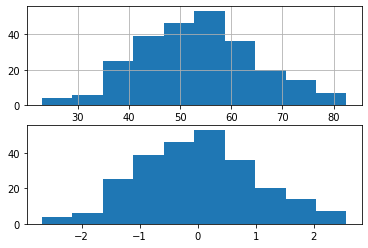

In [34]:
# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]



# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

Nice work! Next we're going to optimize n_neighbors for improved performance.

## Optimize n_neighbors

Now that we have scaled data, we can try using a KNN model. To maximize performance, we should tune our model's hyperparameters. For the k-nearest neighbors algorithm, we only have one hyperparameter: `n`, the number of neighbors. We set this hyperparameter when we create the model with `KNeighborsRegressor`. The argument for the number of neighbors is `n_neighbors`.

We want to try a range of values that passes through the setting with the best performance. Usually we will start with 2 neighbors, and increase until our scoring metric starts to decrease. We'll use the R^2 value from the `.score()` method on the test set (`scaled_test_features` and `test_targets`) to optimize n here. We'll use the test set scores to determine the best `n`.

### Instructions
* Loop through the values of 2 to 12 for `n` and set this as `n_neighbors` in the `knn` model.
* Fit the model to the training data (`scaled_train_features` and `train_targets`). 
* Print out the R^2 values using the `.score()` method of the `knn` model for the train and test sets, and take note of the best score on the test set.

In [35]:
for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.7086590518110245
-0.2457051272374251

n_neighbors = 3
train, test scores
0.6161299695003466
-0.02824798752790114

n_neighbors = 4
train, test scores
0.5698590844708642
0.054069637288982064

n_neighbors = 5
train, test scores
0.5306669823361658
0.09562673296186885

n_neighbors = 6
train, test scores
0.4924157634083257
0.06493624818165344

n_neighbors = 7
train, test scores
0.4638477451246331
0.018590670460287284

n_neighbors = 8
train, test scores
0.4305841272960338
0.03430514088288383

n_neighbors = 9
train, test scores
0.39035273655318137
-0.054993685932298586

n_neighbors = 10
train, test scores
0.3585431044577594
-0.04569165134882858

n_neighbors = 11
train, test scores
0.3100220686973306
-0.08074815512838707

n_neighbors = 12
train, test scores
0.2742940406863563
-0.07302787030122504



Nice work! See how 5 is the best number of neighbors based on the test score?"

## Evaluate KNN performance

We just saw a few things with our KNN scores. For one, the training scores started high and decreased with increasing `n`, which is typical. The test set performance reached a peak at 5 though, and we will use that as our setting in the final KNN model.

As we have done a few times now, we will check our performance visually. This helps us see how well the model is predicting on different regions of actual values. We will get predictions from our `knn` model using the `.predict()` method on our scaled features. Then we'll use `matplotlib`'s `plt.scatter()` to create a scatter plot of actual versus predicted values.

### Instructions
* Set `n_neighborrs` in the `KNeighborsRegressor` to the best performing value of 5.
* Obtain predictions using the `knn` model from the `scaled_train_features` and `scaled_test_features`.
* Create a scatter plot of the `test_targets` versus the `test_predictions` and label it `test`.

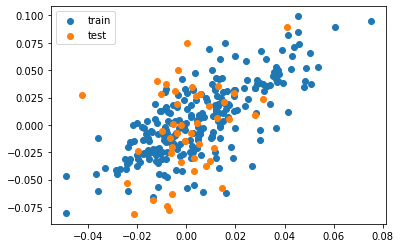

In [36]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors = 5)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

Great work! It looks like this model is showing some hope

## Build and fit a simple neural net
The next model we will learn how to use is a neural network. Neural nets can capture complex interactions between variables, but are difficult to set up and understand. Recently, they have been beating human experts in many fields, including image recognition and gaming (check out AlphaStar from Deepmind) - so they have great potential to perform well.

To build our nets we'll use the `keras` library. This is a high-level API that allows us to quickly make neural nets, yet still exercise a lot of control over the design. The first thing we'll do is create almost the simplest net possible - a 3-layer net that takes our inputs and predicts a single value. Much like the `sklearn` models, keras models have a `.fit()` method that takes arguments of (`features`, `targets`).

### Instructions
* Create a dense layer with 20 nodes and the ReLU (`'relu'`) activation as the 2nd layer in the neural network.
* Create the last dense layer with 1 node and a linear activation (`activation='linear'`).
* Fit the model to the `scaled_train_features` and `train_targets`.

In [37]:
# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
250/250 [==============================] - 2s 9ms/step - loss: 0.0848
Epoch 2/25
250/250 [==============================] - 0s 37us/step - loss: 0.0284
Epoch 3/25
250/250 [==============================] - 0s 40us/step - loss: 0.0157
Epoch 4/25
250/250 [==============================] - 0s 46us/step - loss: 0.0079
Epoch 5/25
250/250 [==============================] - 0s 42us/step - loss: 0.0061
Epoch 6/25
250/250 [==============================] - 0s 51us/step - loss: 0.0045
Epoch 7/25
250/250 [==============================] - 0s 57us/step - loss: 0.0036
Epoch 8/25
250/250 [==============================] - 0s 43us/step - loss: 0.0029
Epoch 9/25
250/250 [==============================] - 0s 38us/step - loss: 0.0024
Epoch 10/25
250/250 [==============================] - 0s 42us/step - loss: 0.0021
Epoch 11/25
250/250 [==============================] - 0s 44us/step - loss: 0.0019
Epoch 12/25
250/250 [==============================] - 0s 45us/step - loss: 0.0018
Epoch 13/25
25

Great work! Now we need to check that our training loss has flattened out and the net is sufficiently trained.

## Plot losses

Once we've fit a model, we usually check the training loss curve to make sure it's flattened out. The `history` returned from `model.fit()` is a dictionary that has an entry, `'loss'`, which is the training loss. We want to ensure this has more or less flattened out at the end of our training.

### Instructions
* Plot the losses (`'loss'`) from `history.history`.
* Set the title of the plot as the last loss from `history.history`, and round it to 6 digits.

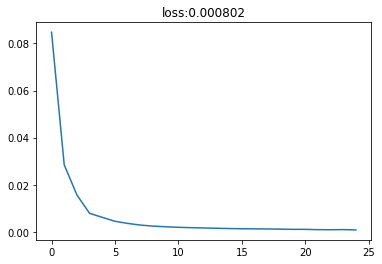

In [39]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

Nice work! We can see our loss has flattened out, so we're good!

### Measure Performance
Now that we've fit our neural net, let's check performance to see how well our model is predicting new values. There's not a built-in `.score()` method like with `sklearn` models, so we'll use the `r2_score()` function from `sklearn.metrics`. This calculates the R^2 score given arguments (`y_true`, `y_predicted`). We'll also plot our predictions versus actual values again. This will yield some interesting results soon (once we implement our own custom loss function).

### Instructions
* Obtain predictions from `model_1` on the scaled test set data (`scaled_test_features` and `test_targets`).
* Print the R^2 score on the test set (`test_targets` and `test_preds`).
* Plot the `test_preds` versus `test_targets` in a scatter plot with `plt.scatter()`.

0.3047513531322057
-1.3069593017842989


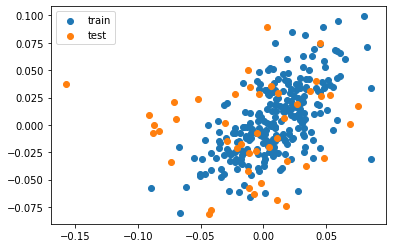

In [40]:
# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

Nice work! It doesn't look too much different from our other models just yet, don't lose hope!

## Custom loss function
Up to now, we've used the mean squared error as a loss function. This works fine, but with stock price prediction it can be useful to implement a custom loss function. A custom loss function can help improve our model's performance in specific ways we choose. For example, we're going to create a custom loss function with a large penalty for predicting price movements in the wrong direction. This will help our net learn to at least predict price movements in the correct direction.

To do this, we need to write a function that takes arguments of (`y_true`, `y_predicted`). We'll also use functionality from the backend `keras` (using `tensorflow`) to find cases where the true value and prediction don't match signs, then penalize those cases.

### Instructions
* Set the arguments of the `sign_penalty(`) function to be `y_true` and `y_pred`.
* Multiply the squared error (`tf.square(y_true - y_pred)`) by penalty when the signs of `y_true` and `y_pred` are different.
* Return the average of the loss variable from the function - this is the mean squared error (with our penalty for opposite signs of actual vs predictions).

In [41]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x1451a25f0>


Great job! Now we'll see how that loss function affects our predictions.

## Fit neural net with custom loss function
Now we'll use the custom loss function we just created. This will enable us to alter the model's behavior in useful ways particular to our problem - it's going to try to force the model to learn how to at least predict price movement direction correctly. All we need to do now is set the `loss` argument in our `.compile()` function to our function name, `sign_penalty`. We'll examine the training loss again to make sure it's flattened out.

### Instructions
* Set the `input_dim` of the first neural network layer to be the number of columns of `scaled_train_features` with the `.shape[1]` property.
* Use the custom `sign_penalty` loss function to `.compile()` our `model_2`.
* Plot the loss from the `history` of the fit. The loss is under `history.history['loss']`.

Epoch 1/25
250/250 [==============================] - 0s 1ms/step - loss: 2.1131
Epoch 2/25
250/250 [==============================] - 0s 44us/step - loss: 0.8833
Epoch 3/25
250/250 [==============================] - 0s 48us/step - loss: 0.4456
Epoch 4/25
250/250 [==============================] - 0s 61us/step - loss: 0.2179
Epoch 5/25
250/250 [==============================] - 0s 77us/step - loss: 0.1857
Epoch 6/25
250/250 [==============================] - 0s 41us/step - loss: 0.1464
Epoch 7/25
250/250 [==============================] - 0s 46us/step - loss: 0.1309
Epoch 8/25
250/250 [==============================] - 0s 46us/step - loss: 0.1027
Epoch 9/25
250/250 [==============================] - 0s 53us/step - loss: 0.0994
Epoch 10/25
250/250 [==============================] - 0s 47us/step - loss: 0.0685
Epoch 11/25
250/250 [==============================] - 0s 41us/step - loss: 0.0604
Epoch 12/25
250/250 [==============================] - 0s 42us/step - loss: 0.0601
Epoch 13/25
25

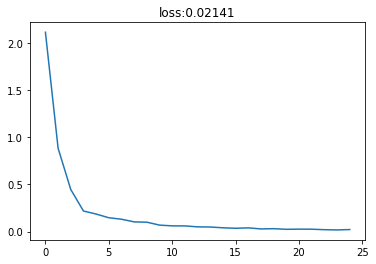

In [45]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

## Visualize the results
We've fit our model with the custom loss function, and it's time to see how it is performing. We'll check the R^2 values again with `sklearn`'s `r2_score()` function, and we'll create a scatter plot of predictions versus actual values with `plt.scatter()`. This will hopefully yield some interesting results!

### Instructions
* Create predictions on the test set with `.predict()`, `model_2`, and `scaled_test_features`.
* Evaluate the R^2 score on the test set predictions using `test_preds` and `test_targets`.
* Plot the test set targets vs actual values with `plt.scatter()`, and label it `'test'`.

-0.19518794813561446
-0.6099854911098084


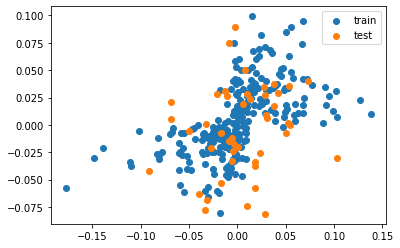

In [46]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

Nice work! Notice how the train set actual vs predictions shape has changed to be a bow-tie.

## Combatting overfitting with dropout
A common problem with neural networks is they tend to overfit to training data. What this means is the scoring metric, like R^2 or accuracy, is high for the training set, but low for testing and validation sets, and the model is fitting to noise in the training data.

We can work towards preventing overfitting by using dropout. This randomly drops some neurons during the training phase, which helps prevent the net from fitting noise in the training data. `keras` has a `Dropout` layer that we can use to accomplish this. We need to set the dropout rate, or fraction of connections dropped during training time. This is set as a decimal between 0 and 1 in the `Dropout()` layer.

We're going to go back to the mean squared error loss function for this model.

### Instructions
* Add a dropout layer (`Dropout()`) after the first Dense layer in the model, and use 20% (0.2) as the dropout rate.
* Use the `adam` optimizer and the mse loss function when compiling the model in `.compile()`.
* Fit the model to the s`caled_train_features` and `train_targets` using 25 epochs.

Epoch 1/25
250/250 [==============================] - 1s 2ms/step - loss: 0.0856
Epoch 2/25
250/250 [==============================] - 0s 46us/step - loss: 0.0389
Epoch 3/25
250/250 [==============================] - 0s 38us/step - loss: 0.0285
Epoch 4/25
250/250 [==============================] - 0s 53us/step - loss: 0.0229
Epoch 5/25
250/250 [==============================] - 0s 42us/step - loss: 0.0134
Epoch 6/25
250/250 [==============================] - 0s 47us/step - loss: 0.0085
Epoch 7/25
250/250 [==============================] - 0s 47us/step - loss: 0.0088
Epoch 8/25
250/250 [==============================] - 0s 51us/step - loss: 0.0078
Epoch 9/25
250/250 [==============================] - 0s 60us/step - loss: 0.0063
Epoch 10/25
250/250 [==============================] - 0s 46us/step - loss: 0.0060
Epoch 11/25
250/250 [==============================] - 0s 53us/step - loss: 0.0056
Epoch 12/25
250/250 [==============================] - 0s 48us/step - loss: 0.0053
Epoch 13/25
25

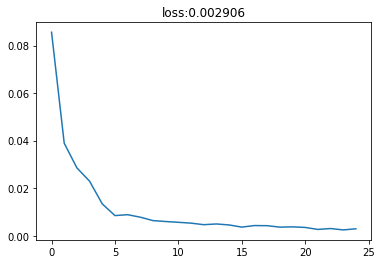

In [49]:
# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

Great job! Dropout helps the model generalized a bit better to unseen data.

## Ensembling models
One approach to improve predictions from machine learning models is ensembling. A basic approach is to average the predictions from multiple models. A more complex approach is to feed predictions of models into *another* model, which makes final predictions. Both approaches usually improve our overall performance (as long as our individual models are good). If you remember, random forests are also using ensembling of many decision trees.

To ensemble our neural net predictions, we'll make predictions with the 3 models we just created -- the basic model, the model with the custom loss function, and the model with dropout. Then we'll combine the predictions with `numpy`'s `.hstack()` function, and average them across rows with `np.mean(predictions, axis=1)`.

### Instructions
* Create predictions on the `scaled_train_features` and `scaled_test_features` for the 3 models we fit (`model_1`, `model_2`, `model_3`) using the `.predict()` method.
* Horizontally stack (`np.hstack()` the predictions into a matrix, and take the row-wise averages to get average predictions for the train and test sets.

In [50]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[-0.00699021  0.02161784  0.04191879 -0.04260431  0.0167666 ]


Good work! Now let's see how our ensemble predictions perform.

## See how the ensemble performed
Let's check performance of our ensembled model to see how it's doing. We should see roughly an average of the R^2 scores, as well as a scatter plot that is a mix of our previous models' predictions. The bow-tie shape from the custom loss function model should still be a bit visible, but the edges near x=0 should be softer.

### Instructions
* Evaluate the R2 scores on the train and test sets. Use the `sklearn` `r2_score()` function (already imported for you) with `train_targets` and `train_preds` from earlier.
* Plot the train and test predictions versus the actual values with `plt.scatter()`.

0.47173484937158006
-0.0062978991058868505


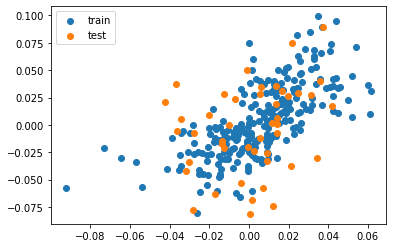

In [51]:
# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()

Nice work! Our R^2 values are around the average of the 3 models we ensembled. Notice the plot also looks like the bow-tie shape has been softened a bit.